In [1]:
from IPython.core.display import display, HTML
from scipy.spatial.transform import Rotation
display(HTML("<style>.container { width:100% !important; }</style>"))
import h5py
from matplotlib import pyplot as plt
import torch
import numpy as np
from pathlib import Path
import glob
import os
import h5py
import numpy as np
import prody
import prody as pr
from potsim2 import PotGrid
import sklearn
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import f1_score
import os
import pandas as pd
import re

import matplotlib
#matplotlib.use('TkAgg')

%matplotlib inline

In [82]:
indexfname = '/home/lorenzo/3dunet-cavity/INDEX_refined_set.2020'

bind_cons = {}

mult = {
    'mM':10**-3,
    'uM':10**-6,
    'nM':10**-9,
    'pM':10**-12,
    'fM':10**-15
}

with open(indexfname) as f:
    for line in f.readlines():
        try:
            cols = line.split()
            name = cols[0]
            k = cols[3].split('=')
            ktype = k[0]
            value = k[1]
            numeric = {*{str(x) for x in range(10)}, *{'.'}}
            num = ''.join(c for c in value if c in numeric)
            units = ''.join(c for c in value if c not in num)
            bind_cons[name] = float(num) * mult[units]
        except IndexError:
            pass

In [2]:
def yieldData(predbase, testData):

    for fname in glob.glob(f'{testData}/*/*_pocket.pdb'):
        pocketfname = Path(fname)
        name = pocketfname.parent.name
        predfname = f'{predbase}/{name}/pocket_pred.pdb'
        pdbfname = f'{testData}/{name}/{name}_selected.pdb'

        
        pocket = prody.parsePDB(pocketfname)
        structure = prody.parsePDB(pdbfname)
        
        size = len(structure)

        try:
            pred = prody.parsePDB(predfname)
            yield name, (structure, pred, pocket), size
            
        except OSError:
            if os.path.exists(predfname+'.empty'):
                print(f'No pockets predicted for {name}, {predbase}')
                yield name, (structure, None, pocket), size
            else:
                print(f'Prediction for name {name} was not found')
        

        
def calcMetric(pred, pocket, structure, scoref):
    if pred is None:
        prednums = set()
    else:
        prednums = set(t.getResnum() for t in pred.iterResidues())
    truenums = set(t.getResnum() for t in pocket.iterResidues())
    allnums = set(t.getResnum() for t in structure.iterResidues())

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    y_true = []
    y_pred = []

    for num in allnums:
        if num not in prednums and num not in truenums:
            tn += 1
            y_pred.append(-1)
            y_true.append(-1)
        elif num not in prednums and num in truenums:
            fn += 1
            y_pred.append(-1)
            y_true.append(1)
        elif num in prednums and num not in truenums:
            fp += 1
            y_pred.append(1)
            y_true.append(-1)
        elif num in prednums and num in truenums:
            tp += 1
            y_pred.append(1)
            y_true.append(1)
        else:
            raise Exception

    return scoref(y_true, y_pred)

def scoresFromGen(gen):
    names = []
    mcc_scores = []
    f_scores = []
    for (name, (structure, pred, pocket), size) in gen:
        yield name, (calcMetric(pred, pocket, structure, f1_score), calcMetric(pred, pocket, structure, mcc)), size

In [3]:
testData = f'/home/lorenzo/3dunet-cavity/procData_210821'

predname = '210914_features_rot_log'
predbase = f'/home/lorenzo/3dunet-cavity/runs/{predname}/predictions'

predbaseKala = '/home/lorenzo/kalasanty/predictions_210821'

In [4]:
resOurs = list(scoresFromGen(yieldData(predbase, testData)))
resTheirs = list(scoresFromGen(yieldData(predbaseKala, testData)))

/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


No pockets predicted for 2jdu, /home/lorenzo/kalasanty/predictions_210821
No pockets predicted for 4pf5, /home/lorenzo/kalasanty/predictions_210821


/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


No pockets predicted for 3t1a, /home/lorenzo/kalasanty/predictions_210821


/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


No pockets predicted for 4l9i, /home/lorenzo/kalasanty/predictions_210821


/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


No pockets predicted for 5f8y, /home/lorenzo/kalasanty/predictions_210821


/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


No pockets predicted for 4b73, /home/lorenzo/kalasanty/predictions_210821


/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


No pockets predicted for 5wxh, /home/lorenzo/kalasanty/predictions_210821


/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


No pockets predicted for 1pgp, /home/lorenzo/kalasanty/predictions_210821


/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


No pockets predicted for 2epn, /home/lorenzo/kalasanty/predictions_210821


/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


No pockets predicted for 4rd6, /home/lorenzo/kalasanty/predictions_210821


/home/lorenzo/miniconda3/envs/apbs/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [5]:
# Our F scores

codes = [code for code,_,_ in resOurs]
sizes = [size for _,_,size in resOurs]
scores = [score for _,(score,_),_ in resOurs]

Text(0, 0.5, 'f score')

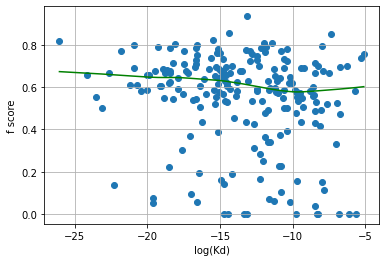

In [86]:
logkds = [np.log(bind_cons[code]) for code in codes]

ys = lowess(scores, logkds)
plt.scatter(logkds,scores)
plt.plot(ys[:,0],ys[:,1], c='g')
plt.grid(b=1)
plt.xlabel('log(Kd)')
plt.ylabel('f score')

Text(0, 0.5, 'f score')

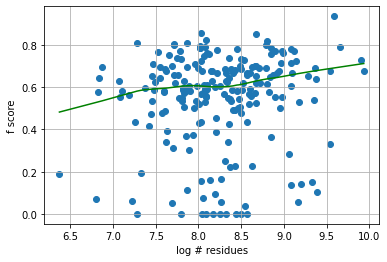

In [89]:
ys = lowess(scores, np.log(sizes))
plt.scatter(np.log(sizes),scores)
plt.plot(ys[:,0],ys[:,1], c='g')
plt.grid(b=1)
plt.xlabel('log # residues')
plt.ylabel('f score')

In [7]:
list(zip(codes,scores))

[('4q19', 0.619718309859155),
 ('1sw2', 0.5454545454545454),
 ('4bcn', 0.5454545454545454),
 ('4da5', 0.6538461538461539),
 ('2q89', 0.6037735849056604),
 ('2wca', 0.7241379310344828),
 ('5yhe', 0.5882352941176471),
 ('5vi6', 0.07692307692307691),
 ('5hjq', 0.375),
 ('3fjg', 0.6),
 ('2vb8', 0.6896551724137931),
 ('1lnm', 0.5846153846153846),
 ('6mjf', 0.3636363636363637),
 ('1rnt', 0.8108108108108109),
 ('5hcv', 0.6567164179104478),
 ('2jfz', 0.25),
 ('2x6x', 0.7142857142857143),
 ('2dw7', 0.10256410256410256),
 ('2gsu', 0.7000000000000001),
 ('2jdu', 0.8235294117647058),
 ('2yfx', 0.6792452830188678),
 ('4pf5', 0.3111111111111111),
 ('3aaq', 0.5205479452054794),
 ('1r9l', 0.5833333333333334),
 ('5ey0', 0.0),
 ('6exi', 0.5882352941176471),
 ('5fol', 0.6666666666666666),
 ('4kif', 0.5769230769230769),
 ('4g0y', 0.7368421052631579),
 ('4o6w', 0.05),
 ('2fqt', 0.6984126984126985),
 ('3ta0', 0.7936507936507937),
 ('5fnu', 0.5833333333333334),
 ('5tuz', 0.3673469387755102),
 ('4xu1', 0.7692

In [8]:
def mergeDict(dx, dy):
    keys = set(dx.keys()) | set(dy.keys())
    return {key:(dx.get(key),dy.get(key)) for key in keys}

dictOurs = {x[0]: x[1] for x in resOurs}
dictTheirs = {x[0]: x[1] for x in resTheirs}
d2 = mergeDict(dictOurs, dictTheirs)

d2

{'2yfx': ((0.6792452830188678, 0.6661754945554865),
  (0.5106382978723405, 0.4714942324003128)),
 '6g35': ((0.59375, 0.6227432261696311),
  (0.6666666666666666, 0.6669392173152435)),
 '1pgp': ((0.9361702127659574, 0.9330686366606287), (0.0, 0.0)),
 '3p2e': ((0.5897435897435898, 0.541453657486834),
  (0.0, -0.09478220329632557)),
 '3nyd': ((0.49122807017543857, 0.5412121560827023),
  (0.5098039215686275, 0.5421237760064133)),
 '4pqa': ((0.7555555555555554, 0.7671294738756601),
  (0.7647058823529412, 0.7535326979953992)),
 '5yz2': ((0.8108108108108109, 0.791335061857001),
  (0.21052631578947367, 0.2559239653166382)),
 '5gja': ((0.5333333333333333, 0.5724143669727942),
  (0.6274509803921569, 0.6530323783922757)),
 '5ldp': ((0.5333333333333333, 0.5424627182360618),
  (0.0, -0.06200131873438054)),
 '3wto': ((0.5660377358490566, 0.5892394133539062),
  (0.14285714285714285, 0.057241221486376385)),
 '6evn': ((0.6451612903225806, 0.6432979088622046),
  (0.6923076923076923, 0.6700036675495997)),

In [9]:
# f1_score ours
np.mean([x[0][0] for k,x in d2.items()]), np.std([x[0][0] for k,x in d2.items()])

(0.5418252737092744, 0.22316135750805463)

In [10]:
# f1_score theirs
np.mean([x[1][0] for k,x in d2.items()]), np.std([x[1][0] for k,x in d2.items()])

(0.4429008739237578, 0.328475892638977)

In [17]:
# mcc ours
np.mean([x[0][1] for k,x in d2.items()]), np.std([x[0][1] for k,x in d2.items()])

(0.5330663002669616, 0.24060644445515278)

In [18]:
# mcc theirs
np.mean([x[1][1] for k,x in d2.items()]), np.std([x[1][1] for k,x in d2.items()])

(0.41869395956563593, 0.34744801749667464)

# Scratch

In [ ]:
testData = f'/home/lorenzo/3dunet-cavity/procData_210821'
predname = '210817_features_cpu'
predbase = f'/home/lorenzo/3dunet-cavity/runs/{predname}/predictions'

In [ ]:
def getSample(predbase, testData, name):

    pocketfname = f'{testData}/{name}/{name}_pocket.pdb'
    predfname = f'{predbase}/{name}/pocket_pred.pdb'
    pdbfname = f'{testData}/{name}/{name}_selected.pdb'

    pocket = prody.parsePDB(pocketfname)
    structure = prody.parsePDB(pdbfname)

    try:
        pred = prody.parsePDB(predfname)
        return structure, pocket, pred

    except OSError:
        return structure, pocket, None